In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
pd.options.display.float_format='{:.5f}'.format #지수표현식 실수표현으로 바꾸기
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score,KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso,ElasticNet,RidgeCV,LassoCV


from sklearn.metrics import mean_squared_error,r2_score



# Regression 
## 당뇨 수치 예측하기

- age     나이 (age in years)
- sex     성별
- bmi     body mass index
- bp      average blood pressure
- s1      총 혈청 콜레스테롤 tc, total serum cholesterol 
- s2      저밀도 지단백질 ldl, low-density lipoproteins
- s3      고밀도 지단백질 hdl, high-density lipoproteins
- s4      총 콜레스테롤 tch, total cholesterol / HDL
- s5      혈청 트리글리세리드 수치일 가능성이 있는  ltg, possibly log of serum triglycerides level
- s6      혈당수치 glu, blood sugar level

### Baseline - 수식으로 구현하는 linearRegression

In [2]:
diabetes = load_diabetes()
print(dir(diabetes))

['DESCR', 'data', 'data_filename', 'data_module', 'feature_names', 'frame', 'target', 'target_filename']


In [3]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [4]:
#label 값을 제외한 나머지 값들이 mean,std 동일하게 세팅되어있음. == 스케일링 불필요.
df_prac = pd.DataFrame(data=diabetes.data,columns=diabetes.feature_names).copy()
df_prac.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


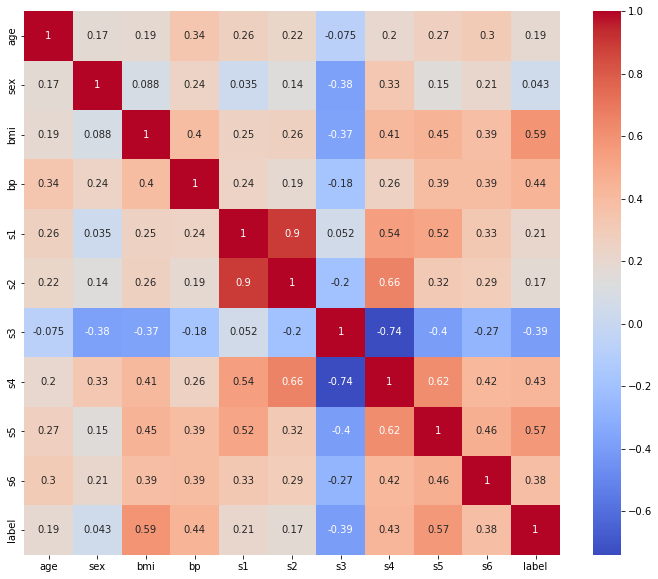

In [5]:
#당뇨수치와 변수들간 상관관계 
df_prac['label'] = pd.DataFrame(data=diabetes.target)
plt.figure(figsize=(12,10))
sns.heatmap(df_prac.corr(),cmap='coolwarm',annot=True)
plt.show()

In [6]:
#데이터 스플릿 이전 x,y값 설정.
df_x = pd.DataFrame(data=diabetes.data,columns=diabetes.feature_names).values
df_x,df_x.shape

(array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 (442, 10))

In [7]:
df_y = diabetes.target #당뇨 수치
df_y, df_y.shape

(array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
        128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
        150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
        200., 252., 113., 143.,  51.,  52., 210.,  65., 141.,  55., 134.,
         42., 111.,  98., 164.,  48.,  96.,  90., 162., 150., 279.,  92.,
         83., 128., 102., 302., 198.,  95.,  53., 134., 144., 232.,  81.,
        104.,  59., 246., 297., 258., 229., 275., 281., 179., 200., 200.,
        173., 180.,  84., 121., 161.,  99., 109., 115., 268., 274., 158.,
        107.,  83., 103., 272.,  85., 280., 336., 281., 118., 317., 235.,
         60., 174., 259., 178., 128., 

In [8]:
#데이터 스플릿
X_train,X_test,y_train,y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((353, 10), (353,), (89, 10), (89,))

### LinearRegression 모델 설정

In [9]:
#초기 값 설정 W,b 
W = np.random.rand(10) # 피쳐 개수에 따른 가중치 개수 설정
b = np.random.rand() # 절편값

def model(X, W, b): # 피쳐 개수만큼 돌면서 wx+b의 형태로 학습하는 모습을 볼 수 있다.
    predictions = 0
    for i in range(10):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

In [10]:
def MSE(a, b):
    mse = ((a - b) ** 2).mean()  # 두 값의 차이의 제곱의 평균
    return mse

def loss(X, W, b, y): #비용함수 계산
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [11]:
def gradient(X, W, b, y):
    # N은 데이터의 개수 *서현님의 피드백으로 수정*
    N = len(y)
    
    # y_pred 준비
    y_pred = model(X, W, b)
    
    # 공식에 맞게 gradient 계산 dot : 행렬의 곱
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    # b의 gradient 계산
    db = 2 * (y_pred - y).mean()
    return dW, db

In [12]:
dW, db = gradient(df_x, W, b, df_y)
print("dW:", dW)
print("db:", db)

dW: [-1.3718263  -0.31410228 -4.2909756  -3.22747938 -1.54682046 -1.27014398
  2.89212187 -3.14970147 -4.13980961 -2.79619246]
db: -302.5229660770154


In [13]:
LEARNING_RATE =0.3
losses = []

for i in range(1, 1001):
    dW, db = gradient(X_train, W, b, y_train)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(X_train, W, b, y_train)
    losses.append(L)
    if i % 10 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 10 : Loss 5836.4687
Iteration 20 : Loss 5628.4652
Iteration 30 : Loss 5439.0841
Iteration 40 : Loss 5266.4962
Iteration 50 : Loss 5109.0581
Iteration 60 : Loss 4965.2922
Iteration 70 : Loss 4833.8704
Iteration 80 : Loss 4713.5988
Iteration 90 : Loss 4603.4034
Iteration 100 : Loss 4502.3186
Iteration 110 : Loss 4409.4757
Iteration 120 : Loss 4324.0930
Iteration 130 : Loss 4245.4673
Iteration 140 : Loss 4172.9654
Iteration 150 : Loss 4106.0174
Iteration 160 : Loss 4044.1100
Iteration 170 : Loss 3986.7808
Iteration 180 : Loss 3933.6133
Iteration 190 : Loss 3884.2320
Iteration 200 : Loss 3838.2983
Iteration 210 : Loss 3795.5069
Iteration 220 : Loss 3755.5823
Iteration 230 : Loss 3718.2758
Iteration 240 : Loss 3683.3629
Iteration 250 : Loss 3650.6407
Iteration 260 : Loss 3619.9259
Iteration 270 : Loss 3591.0525
Iteration 280 : Loss 3563.8706
Iteration 290 : Loss 3538.2443
Iteration 300 : Loss 3514.0505
Iteration 310 : Loss 3491.1777
Iteration 320 : Loss 3469.5247
Iteration 330 : L

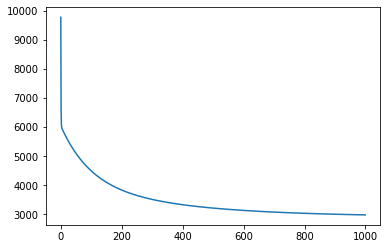

In [14]:
plt.plot(losses)
plt.show()

In [15]:
prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
mse

2870.3062988697634

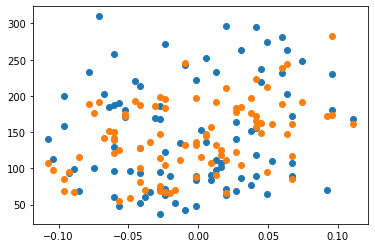

In [16]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)
plt.show()

### PolynomialFeatures 와 LinearRegression
- 복수의 feature와 label의 관계를 나타낼수있도록 feature간 곱셈을 통해 새로운 feature를 생성

In [17]:
#컬럼2개의 조합들을 생성해 라벨과 상관관계가 있는 유의미한 데이터 찾아내기
df_prac = pd.DataFrame(data=diabetes.data,columns=diabetes.feature_names).copy()
poly_features = PolynomialFeatures(degree=2,include_bias=False)
poly = poly_features.fit_transform(df_prac)
poly[0]

array([ 3.80759064e-02,  5.06801187e-02,  6.16962065e-02,  2.18723550e-02,
       -4.42234984e-02, -3.48207628e-02, -4.34008457e-02, -2.59226200e-03,
        1.99084209e-02, -1.76461252e-02,  1.44977465e-03,  1.92969146e-03,
        2.34913899e-03,  8.32809742e-04, -1.68384979e-03, -1.32583211e-03,
       -1.65252654e-03, -9.87027253e-05,  7.58031171e-04, -6.71892210e-04,
        2.56847444e-03,  3.12677107e-03,  1.10849355e-03, -2.24125215e-03,
       -1.76472040e-03, -2.19956001e-03, -1.31376146e-04,  1.00896113e-03,
       -8.94307718e-04,  3.80642190e-03,  1.34944133e-03, -2.72842209e-03,
       -2.14830898e-03, -2.67766754e-03, -1.59932732e-04,  1.22827405e-03,
       -1.08869898e-03,  4.78399913e-04, -9.67272057e-04, -7.61612086e-04,
       -9.49278703e-04, -5.66988747e-05,  4.35444049e-04, -3.85962314e-04,
        1.95571781e-03,  1.53989595e-03,  1.91933723e-03,  1.14638894e-04,
       -8.80420019e-04,  7.80373388e-04,  1.21248552e-03,  1.51125055e-03,
        9.02645403e-05, -

In [18]:
#데이터 스플릿
X_train,X_test,y_train,y_test = train_test_split(poly,df_y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((353, 65), (353,), (89, 65), (89,))

In [19]:
#초기 값 설정 W,b 
W = np.random.rand(65) #poly로 인해 늘어난 피쳐값 반영
b = np.random.rand()

def model(X, W, b):
    predictions = 0
    for i in range(65):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

def MSE(a, b):
    mse = ((a - b) ** 2).mean()  # 두 값의 차이의 제곱의 평균
    return mse

def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

def gradient(X, W, b, y):
    # N은 데이터의 개수
    N = len(y)
    
    # y_pred 준비
    y_pred = model(X, W, b)
    
    # 공식에 맞게 gradient 계산 dot : 행렬의 곱
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    # b의 gradient 계산
    db = 2 * (y_pred - y).mean()
    return dW, db

dW, db = gradient(poly, W, b, df_y)
print("dW:", dW)
print("db:", db)

dW: [-1.36722745 -0.3118071  -4.28755721 -3.22348834 -1.5417741  -1.26560123
  2.88861774 -3.14384866 -4.13374715 -2.79087784 -0.68031799 -0.13867501
 -0.11064556 -0.25330099 -0.13903143 -0.09727782  0.06645302 -0.13413092
 -0.20197234 -0.22200746 -0.68731887 -0.07612778 -0.18457527 -0.0297272
 -0.08450512  0.23195611 -0.22152225 -0.11382924 -0.15528458 -0.81235476
 -0.32547968 -0.14870263 -0.14202524  0.26863105 -0.30373598 -0.33856216
 -0.32111291 -0.75250853 -0.16249944 -0.09912791  0.11701124 -0.17538024
 -0.30213238 -0.29628433 -0.69904455 -0.61793816 -0.02680372 -0.38796842
 -0.3607242  -0.23534084 -0.68738001  0.10438098 -0.44389456 -0.18590242
 -0.19341748 -0.61573286  0.50749554  0.27785575  0.21607616 -0.74568466
 -0.45120065 -0.33713947 -0.72305541 -0.36405293 -0.75569253]
db: -302.9627244399652


In [20]:
LEARNING_RATE =0.09
losses = []

for i in range(1, 5001):
    dW, db = gradient(X_train, W, b, y_train)
    W -= LEARNING_RATE * dWㄹ
    b -= LEARNING_RATE * db
    L = loss(X_train, W, b, y_train)
    losses.append(L)
    if i % 10 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 10 : Loss 6430.4070
Iteration 20 : Loss 5927.5058
Iteration 30 : Loss 5852.5693
Iteration 40 : Loss 5787.5447
Iteration 50 : Loss 5724.4814
Iteration 60 : Loss 5663.1750
Iteration 70 : Loss 5603.5692
Iteration 80 : Loss 5545.6118
Iteration 90 : Loss 5489.2526
Iteration 100 : Loss 5434.4429
Iteration 110 : Loss 5381.1356
Iteration 120 : Loss 5329.2849
Iteration 130 : Loss 5278.8466
Iteration 140 : Loss 5229.7777
Iteration 150 : Loss 5182.0369
Iteration 160 : Loss 5135.5839
Iteration 170 : Loss 5090.3797
Iteration 180 : Loss 5046.3867
Iteration 190 : Loss 5003.5683
Iteration 200 : Loss 4961.8890
Iteration 210 : Loss 4921.3147
Iteration 220 : Loss 4881.8121
Iteration 230 : Loss 4843.3491
Iteration 240 : Loss 4805.8944
Iteration 250 : Loss 4769.4180
Iteration 260 : Loss 4733.8906
Iteration 270 : Loss 4699.2838
Iteration 280 : Loss 4665.5702
Iteration 290 : Loss 4632.7233
Iteration 300 : Loss 4600.7172
Iteration 310 : Loss 4569.5272
Iteration 320 : Loss 4539.1289
Iteration 330 : L

Iteration 2620 : Loss 3035.2280
Iteration 2630 : Loss 3034.0884
Iteration 2640 : Loss 3032.9587
Iteration 2650 : Loss 3031.8389
Iteration 2660 : Loss 3030.7288
Iteration 2670 : Loss 3029.6283
Iteration 2680 : Loss 3028.5373
Iteration 2690 : Loss 3027.4558
Iteration 2700 : Loss 3026.3836
Iteration 2710 : Loss 3025.3207
Iteration 2720 : Loss 3024.2670
Iteration 2730 : Loss 3023.2223
Iteration 2740 : Loss 3022.1867
Iteration 2750 : Loss 3021.1599
Iteration 2760 : Loss 3020.1420
Iteration 2770 : Loss 3019.1328
Iteration 2780 : Loss 3018.1322
Iteration 2790 : Loss 3017.1402
Iteration 2800 : Loss 3016.1567
Iteration 2810 : Loss 3015.1816
Iteration 2820 : Loss 3014.2148
Iteration 2830 : Loss 3013.2563
Iteration 2840 : Loss 3012.3059
Iteration 2850 : Loss 3011.3636
Iteration 2860 : Loss 3010.4293
Iteration 2870 : Loss 3009.5030
Iteration 2880 : Loss 3008.5845
Iteration 2890 : Loss 3007.6738
Iteration 2900 : Loss 3006.7708
Iteration 2910 : Loss 3005.8755
Iteration 2920 : Loss 3004.9877
Iteratio

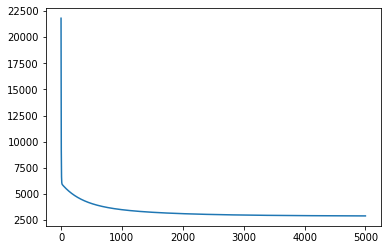

In [21]:
plt.plot(losses)
plt.show()

In [22]:
#PolyNomial으로는 loss에 큰 영향을 줄수없음을 확인.
prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
mse

2856.271266496387

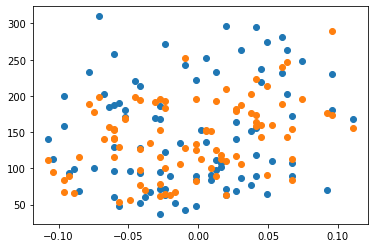

In [23]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)
plt.show()

### K-Fold , LinearRegression
- train_test_split의 경우 random_state의 값을 어떻게 주는가에 따라서 loss값이 달라진다. 하지만 특정 random_state에서 가장 낮은 loss를 기록할 때 해당하는 모델을 선정하는 것은 신뢰성이 낮다고 생각함.
- K-Fold 실습을 통해서 어느정도의 차이가 있는지 확인하고자 함.

- 실제 결과값을 통해 Random_state 고정과 loss의 차이가 있음을 확인 할 수 있다.

In [27]:
#K-Fold
linear_reg = LinearRegression()
kfold = KFold(n_splits=5) #5개의 데이터셋으로 나눠서 검증
cv_acc = []
n_iter = 0 #교차검증 횟수
for train_index,test_index in kfold.split(diabetes.data):
    X_trainFold,X_testFold = diabetes.data[train_index],diabetes.data[test_index]
    y_trainFold,y_testFold = df_y[train_index],df_y[test_index]
    
    linear_reg.fit(X_trainFold,y_trainFold)
    pred = linear_reg.predict(X_testFold)
    n_iter += 1 
    sco = linear_reg.score(X_trainFold,y_trainFold) #TRAIN DATA의 R2
    score = linear_reg.score(X_testFold,y_testFold) #TEST R2
    acc = np.round(mean_squared_error(y_testFold,pred),4)
    train_size = X_trainFold.shape[0] 
    test_size = X_testFold.shape[0]
    
    print(f'{n_iter}회차 mse : {acc}, 검증 set index : {test_index[0],test_index[-1]}')
    cv_acc.append(acc)
    print(f'평균 검증 mse : {np.mean(cv_acc)},R2 : {score:.04f},train R2 : {sco:.04f}')
    

1회차 mse : 2779.9221, 검증set index : (0, 88)
평균 검증 mse : 2779.9221,R2 : 0.4296,train R2 : 0.5243
2회차 mse : 3028.8434, 검증set index : (89, 177)
평균 검증 mse : 2904.3827499999998,R2 : 0.5226,train R2 : 0.5103
3회차 mse : 3237.701, 검증set index : (178, 265)
평균 검증 mse : 3015.488833333333,R2 : 0.4827,train R2 : 0.5238
4회차 mse : 3008.6913, 검증set index : (266, 353)
평균 검증 mse : 3013.7894499999998,R2 : 0.4265,train R2 : 0.5314
5회차 mse : 2910.2069, 검증set index : (354, 441)
평균 검증 mse : 2993.0729399999996,R2 : 0.5502,train R2 : 0.5078


#### 일반적으로는 오버피팅의 가능성을 줄이기 위해 사용한다고 보았지만, PolyNomialfeatures의 효과를 확인하고 싶어 적용함.
### Lasso(L1) 
- 가중치들의 절대값 합이 최소가 되게 만드는 패널티(L1)을 적용하는 모델로 영향력이 적은 피쳐에 대해서 Gradient descent 시에 강력한 규제(0으로 수렴)를 시행함


### LIdge(L2)
- L2 패널티를 사용한다는 점에서 차이가 있으며, 가중치들을 0에 가깝도록 조정은 하지만, Lasso에 비해 완만한 편이다. 

### ElasticNet
- L1,L2 패널티를 적절하게 섞어서 사용한다는 개념이지만, 실제 어떻게 하이퍼파라미터 값을 줘야할지 막막한 부분이 있었다. 스코어로 보았을때도 선형회귀와 유의미한 차이를 보이지는 못한 것 같다.

In [ ]:
#polynomialfeature를 적용한 데이터 스플릿
X_train,X_test,y_train,y_test = train_test_split(poly,df_y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

In [ ]:
#Lasso 실습
# train_score = []
# test_score = []
alpha_list = [0.001,0.0015,0.002,0.003,0.005,0.01,0.1,1] #여러 번의 반복을통해 MSE가 최소화되는 값에 근접한 alpha를 선정
# alpha_list = np.arange(0.001,0.005,0.0001)
for i in alpha_list:
    lasso = Lasso(alpha = i,max_iter=10000)
    lasso.fit(X_train,y_train)
    score = lasso.score(X_test,y_test) #R2
    pred_y = lasso.predict(X_test)
    mse = mean_squared_error(y_test,pred_y)
    print(f"Alpha : {i}, MSE:{mse:.04f},R2 : {score:.05f}")
    print('삭제된 특성 : ',np.sum(lasso.coef_ == 0),'사용된 특성 : ',np.sum(lasso.coef_ != 0))
    print('----'*10)
    
#     print(lasso.score(X_train,y_train))
#     print(lasso.score(X_test,y_test))

In [ ]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], pred_y)
plt.show()

In [ ]:
#LassoCV 실습 CV는 Fold를 의미함. 
# train_score = []
# test_score = []
alpha_list = [1,2,100,1000,10000]
# alpha_list = np.arange(0.001,0.005,0.0001)
for i in alpha_list:
    lasso = LassoCV(n_alphas = i,max_iter=10000)
    lasso.fit(X_train,y_train)
    score = lasso.score(X_test,y_test) #R2
    pred_y = lasso.predict(X_test)
    mse = mean_squared_error(y_test,pred_y)
    print(f"Alpha : {i}, MSE:{mse:.04f},R2 : {score:.05f}")
    print('삭제된 특성 : ',np.sum(lasso.coef_ == 0),'사용된 특성 : ',np.sum(lasso.coef_ != 0))
    print('----'*10)
    
#     print(lasso.score(X_train,y_train))
#     print(lasso.score(X_test,y_test))

In [ ]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], pred_y)
plt.show()

In [ ]:
#ridge
# alpha_list = [0.001,0.01,0.1,0.15,1,10,100]
alpha_list = np.arange(0.0001,0.001,0.0001)
for j in alpha_list:
    ridge = Ridge(alpha=j).fit(X_train,y_train)
    score = ridge.score(X_test,y_test) #R2
    pred_y = ridge.predict(X_test)
    mse = mean_squared_error(y_test,pred_y)
    print(f"Alpha : {j}, MSE:{mse:.04f}, R2 : {score:.04f}")
#     print(ridge.coef_.[10:])
    print('----'*10)


In [ ]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], pred_y)
plt.show()

In [ ]:
#ridgeCV
# alpha_list = [0.001,0.01,0.1,0.15,1,10,100]
alpha_list = np.arange(0.0001,0.001,0.0001)
ridge = RidgeCV(alphas=alpha_list,cv=5).fit(X_train,y_train)
score = ridge.score(X_test,y_test) #R2
pred_y = ridge.predict(X_test)
mse = mean_squared_error(y_test,pred_y)
print(f"Alpha : {ridge.alpha_}, MSE:{mse:.04f}, R2 : {score:.04f}")
#     print(ridge.coef_.[10:])
print('----'*10)

In [ ]:
#정답률 시각화
plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], pred_y)
plt.show()

In [ ]:
#영향력이 적은 feature에 대해서 강력하게 규제하는 Lasso
coef_lasso = pd.Series(lasso.coef_).sort_values()
coef_lasso.plot(kind='bar',title='Lasso Modal Coef')

In [ ]:
#영향력이 적은 feature에 대해 약하게 규제하는 Ridge
coef_ridge = pd.Series(ridge.coef_).sort_values()
coef_ridge.plot(kind='bar',title='Ridge Modal Coef')

In [ ]:
elastic = ElasticNet(alpha=0.001,l1_ratio=0.7) #
elastic.fit(X_train,y_train)
score = elastic.score(X_test,y_test)
pred_y = elastic.predict(X_test)
mse = mean_squared_error(y_test,pred_y)
print(f"MSE : {mse}")

## 자전거 수요예측

- datetime 
    시간별 날짜 + 타임스탬프
    
- season:  
    1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
    
    
- holiday 
    그 날이 휴일로 간주되는지 여부
- workingday
    요일이 주말도 휴일도 아닌 여부
- weather 
    1. 맑음, 약간 흐림, 약간 흐림
    2. 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간의 구름, 안개
    3. 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
    4. 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개 
    
    
- temp (섭씨 온도)
- atemp (섭씨 체감 온도)
- humidity(상대 습도)
- windspeed (풍속)
- casual 
    시작된 등록되지 않은 사용자 대여 수
    
- registered 
    시작된 등록된 사용자 대여 수
- count 총 대여 횟수

In [50]:
#train data 불러오기와 날짜 데이터의 타입 변환
biycle_train = pd.read_csv('~/data/data/bike-sharing-demand/train.csv')
biycle_train['datetime']= pd.to_datetime(biycle_train['datetime'])
biycle_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [51]:
#날짜 데이터를 쪼개어 새로운 컬럼으로 생성.
biycle_train['year'] = biycle_train['datetime'].dt.year
biycle_train['month'] = biycle_train['datetime'].dt.month
biycle_train['day'] = biycle_train['datetime'].dt.day
biycle_train['hour'] = biycle_train['datetime'].dt.hour
biycle_train['minute'] = biycle_train['datetime'].dt.minute
biycle_train['second'] = biycle_train['datetime'].dt.second
# 요일 (0: 월 ~ 6: 일)
biycle_train['dayofweek'] = biycle_train['datetime'].dt.dayofweek
biycle_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  minute      10886 non-

In [52]:
biycle_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0,10886.0,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,0.0,0.0,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,0.0,0.0,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,0.0,0.0,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,0.0,0.0,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,0.0,0.0,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,0.0,0.0,6.000000


<AxesSubplot:xlabel='second', ylabel='count'>

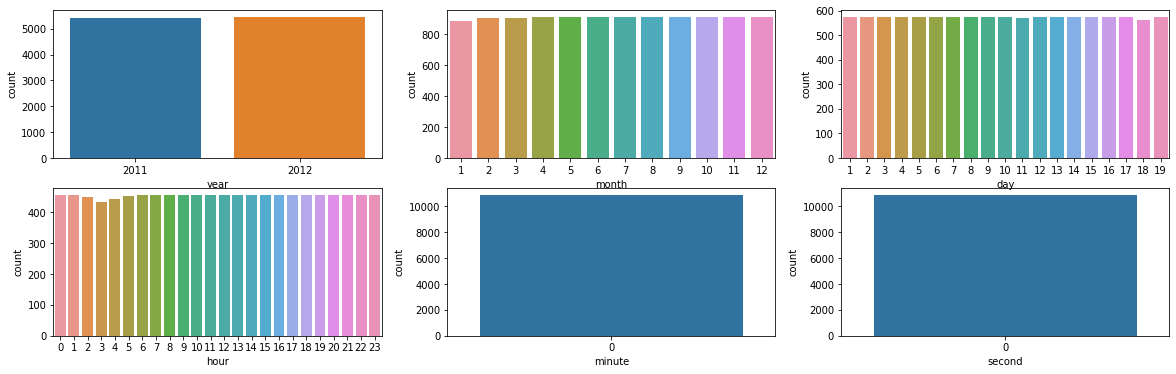

In [53]:
#데이터 count 시각화
#minute , second는 모든 값들이 0으로 크게 의미없는 데이터임을 알수있다.
plt.figure(figsize=(20,6))
plt.subplot(236)
plt.subplot(231)
sns.countplot(x=biycle_train['year'])
plt.subplot(232)
sns.countplot(x=biycle_train['month'])
plt.subplot(233)
sns.countplot(x=biycle_train['day'])
plt.subplot(234)
sns.countplot(x=biycle_train['hour'])
plt.subplot(235)
sns.countplot(x=biycle_train['minute'])
plt.subplot(236)
sns.countplot(x=biycle_train['second'])

In [61]:
#불필요한 컬럼 제거
biycle_train = biycle_train[['year','month','day','hour','dayofweek','season','holiday','workingday','weather','temp'
                   ,'atemp','humidity','windspeed','count']]
biycle_train.head()

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81,0.0,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80,0.0,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80,0.0,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75,0.0,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75,0.0,1


In [55]:
#label 값인 count와 상관관계가 어떻게 형성되어있는지 확인.
#수치형 데이터들의 상관관계가 높음. + 범주형 데이터의 더미변수화가 필요함.
biycle_train.corr()

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
year,1.000000,-0.004932,0.001800,-0.004234,-0.003785,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.260403
month,-0.004932,1.000000,0.001974,-0.006818,-0.002266,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.150192,0.166862
day,0.001800,0.001974,1.000000,0.001132,-0.011070,0.001729,-0.015877,0.009829,-0.007890,0.015551,0.011866,-0.011335,0.036157,0.019826
hour,-0.004234,-0.006818,0.001132,1.000000,-0.002925,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.400601
dayofweek,-0.003785,-0.002266,-0.011070,-0.002925,1.000000,-0.010553,-0.191832,-0.704267,-0.047692,-0.038466,-0.040235,-0.026507,-0.024804,-0.002283
season,-0.004797,0.971524,0.001729,-0.006546,-0.010553,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.012021,0.001731,-0.015877,-0.000354,-0.191832,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.002482,-0.003394,0.009829,0.002780,-0.704267,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,-0.012548,0.012144,-0.007890,-0.022740,-0.047692,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.061226,0.257589,0.015551,0.145430,-0.038466,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454


In [66]:
#더미 변수 생성
dummy_biycle = pd.get_dummies(biycle_train,columns=['year','month','day','hour','dayofweek','season','holiday','workingday','weather'],drop_first=True)
dummy_biycle = dummy_biycle.drop(columns='count')
dummy_biycle.head()

,temp,atemp,humidity,windspeed,year_2012,month_2,month_3,month_4,month_5,month_6,...,dayofweek_5,dayofweek_6,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [67]:
#데이터 스플릿
X_train,X_test,y_train,y_test = train_test_split(dummy_biycle,biycle_train['count'],test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8708, 71), (8708,), (2178, 71), (2178,))

In [69]:
dummy_biycle.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'year_2012', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'season_2', 'season_3', 'season_4', 'holiday_1',
       'workingday_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [70]:
#모델 학습 및 평가
linear = LinearRegression()
linear.fit(X_train,y_train)
pred = linear.predict(X_test)
mse = mean_squared_error(y_test,pred)
rmse = mse**0.5
print(f'MSE : {mse},RMSE : {rmse}')

MSE : 10006.38456283429,RMSE : 100.03191772046705


<AxesSubplot:xlabel='humidity'>

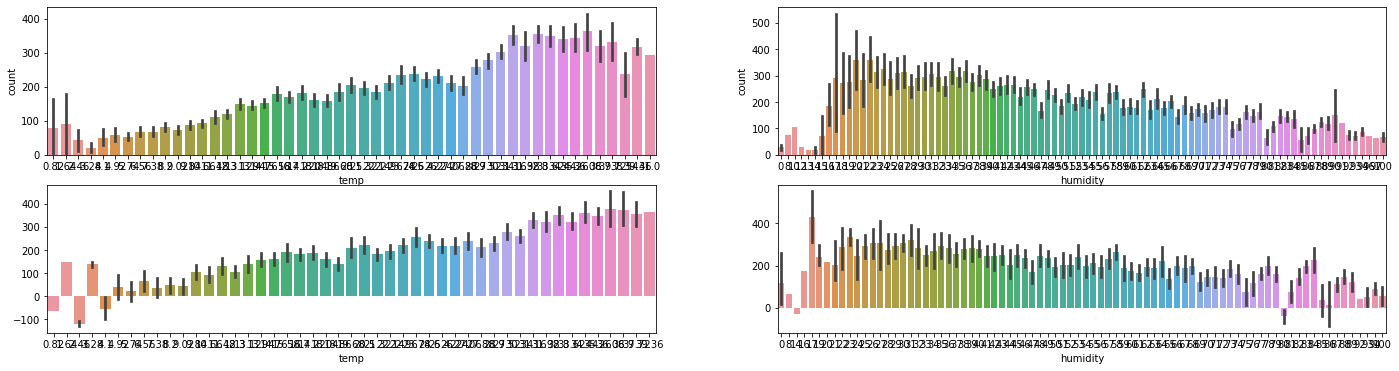

In [72]:
#상단의 2개 그래프는 원본데이터 하단 2개는 X_test data로 예측한 count
plt.figure(figsize=(24,6))
plt.subplot(224)
plt.subplot(221)
sns.barplot(x='temp',y='count',data=biycle_train)
plt.subplot(222)
sns.barplot(x='humidity',y='count',data=biycle_train)
plt.subplot(223)
sns.barplot(x=X_test['temp'],y=pred)
plt.subplot(224)
sns.barplot(x=X_test['humidity'],y=pred)

# 회고록

### 2-1 당뇨 수치 예측하기.
- Linear Regression의 구성에 대해 실습해볼 수 있는 좋은 기회였습니다. 스케일링이 마무리 되어있는 데이터 셋에 대해서 어떻게 추가적으로 전처리를 해줘야 loss를 최소화 할 수 있을지 아직 의문이 남습니다. 이전의 분류 과제에서는 column에 임의의 가중치를 추가하는 방식으로 분석가가 원하는 부분에 가중 해봤었는데, 회귀모델에서는 가중치를 모델이 결정하고 이를 경사하강법으로 조정해나가는 프로세스를 가지는 것을 볼 때 learning rate를 제외한 다른 부분에서 어떻게 처리해야할지 난해했습니다. 
- PolynomialFeatures와 Lasso,Ridge 등을 사용하여 loss 최소화를 달성하고자 했습니다. 실제 결과 값에서도 유의미한 차이를 보였으나 Fold를 함께 사용하는 CV모델들의 사용법을 잘 이해하지 못해서 충분히 파라미터 조정하지 못했던 부분이 아쉬운 점. 엘라스틱 넷의 경우에도 이론적 배경이 부족해 적절한 비율을 찾아내지 못했습니다.

### 2-2 자전거 수요 예측
- 앞의 당뇨수치 예측과 가장 큰 차이는 범주형데이터의 유무였습니다. 이 범주형 데이터 처리를 어떻게 하는가에 따라서 RMSE 값에 유의미한 차이가 생길 수 있음을 확인하였습니다. 단순히 상관관계상으로 높은 것에 집중하는 것이 아니라 범주형데이터가 상관관계가 낮을수밖에 없는 이유(value의 크기에 따른 머신이 받아들이는 인식 혹은 설명력으로 인해 생기는 ERROR)를 이해하고 지정용님의 조언으로 더미변수 생성을 통해서 RMSE를 100까지 낮출 수 있었습니다.